In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

from random import random

# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

import cv2
import numpy as np
import json
from google.colab.patches import cv2_imshow

In [45]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage.color import gray2rgb
from random import random


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [36]:
with open("all_configs.txt") as cfgFile:
  all_configs = cfgFile.readlines()

all_configs = [x.strip() for x in all_configs]
#print(all_configs)

In [74]:
_i_ = 5

In [75]:
with open(f"./my_scene_graph_{_i_}.json") as jsonFile:
  jsonBBox = json.load(jsonFile)[f'{_i_}']

#print(json.dumps(jsonBBox, indent=2))
new_json = jsonBBox

In [40]:
def calculateIOU(boxA, boxB):
  # determine the (x, y)-coordinates of the intersection rectangle
  
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])
  # compute the area of intersection rectangle
  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = interArea / float(boxAArea + boxBArea - interArea)
  # return the intersection over union value
  return iou

In [41]:
def random_color():
    r = abs(random()*1000)%256
    g = abs(random()*1000)%256
    b = abs(random()*1000)%256
    return (r,g,b)

In [76]:
#for fileName in listdir(picsFolder):
#  im = cv2.imread(picsFolder + fileName)
#  outputs = predictor(im)
#  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
#  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#  cv2.imwrite(outputFolder + fileName, out.get_image()[:, :, ::-1])

for cfgLine in all_configs:
  try:
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(cfgLine))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(cfgLine)


    predictor = DefaultPredictor(cfg)
    im = cv2.imread(f'./{_i_}.jpg')
    outputs = predictor(im)

    for i in range(len(outputs["instances"].pred_boxes)):
      bx = outputs["instances"].pred_boxes[i]
      boxA = bx.tensor.cpu().numpy().flatten()
      maxIOU = 0
      id = -1
      for objBBox in jsonBBox["objects"]:
        tempObj = jsonBBox["objects"][str(objBBox)]
        start_x = tempObj["x"]
        start_y = tempObj["y"]
        w = tempObj["w"]
        h = tempObj["h"]
        end_x = start_x + w
        end_y = start_y + h

        #boxB = [tempObj['xStart'], tempObj['yStart'], tempObj['xEnd'], tempObj['yEnd']]
        boxB = [start_x, start_y, end_x, end_y]
        ret = calculateIOU(boxA, boxB)
        if ret > maxIOU:
          id = objBBox
          maxIOU = ret

      # Threshold set for 0.5
      if maxIOU >= 0.5:
        if "iou" in new_json["objects"][str(id)]:
          if maxIOU > new_json["objects"][str(id)]["iou"]:
            new_json["objects"][str(id)]["iou"] = maxIOU
            new_json["objects"][str(id)]["masks"] = outputs["instances"].pred_masks[i].cpu().numpy().tolist()
            new_json["objects"][str(id)]["bbox"] = boxA.tolist()
        else:
          new_json["objects"][str(id)]["iou"] = maxIOU
          new_json["objects"][str(id)]["mask"] = outputs["instances"].pred_masks[i].cpu().numpy().tolist()
          new_json["objects"][str(id)]["bbox"] = boxA.tolist()
  except:
        print("error with cfg: ", cfgLine)

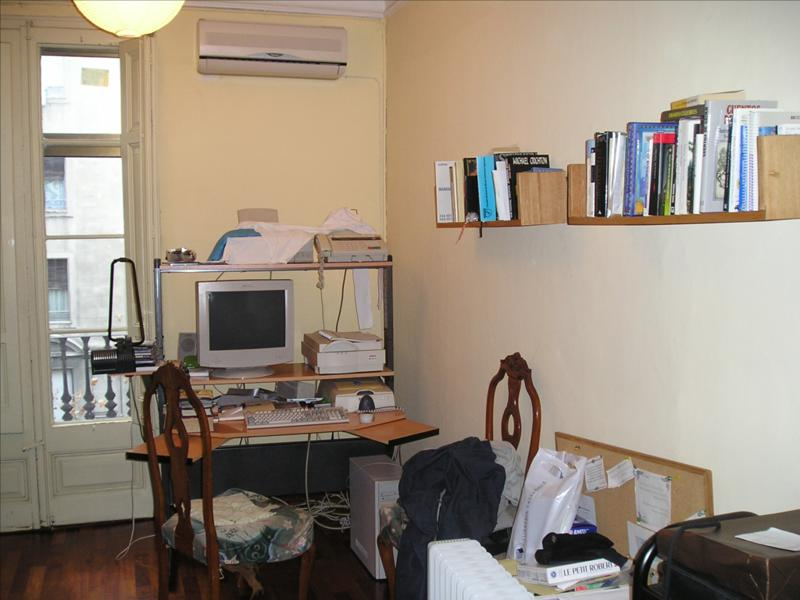

In [77]:
image = cv2.imread(f"./{_i_}.jpg")
cv2_imshow(image)

In [ ]:
!mkdir masks

In [78]:
for obj in new_json["objects"]:
  if "bbox" in new_json["objects"][obj]:
    bbox = new_json["objects"][obj]["bbox"]

    color = random_color()
    cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, 1)

    arr = new_json["objects"][str(obj)]["mask"]
    maskArr = np.array(arr, dtype=np.uint8) * 255
    maskImg = Image.fromarray(maskArr, mode='L')
    maskImg.save(f"./{str(obj)}.jpg")
    maskImg = cv2.imread(f"./{str(obj)}.jpg")
    maskColored = cv2.bitwise_and(image.astype(float), maskImg.astype(float)).astype(float)
    mask = maskImg * maskColored
    mask = cv2.bitwise_and(mask, color)
    image = cv2.addWeighted(image.astype(float), 1, mask.astype(float), 1.5, 0)

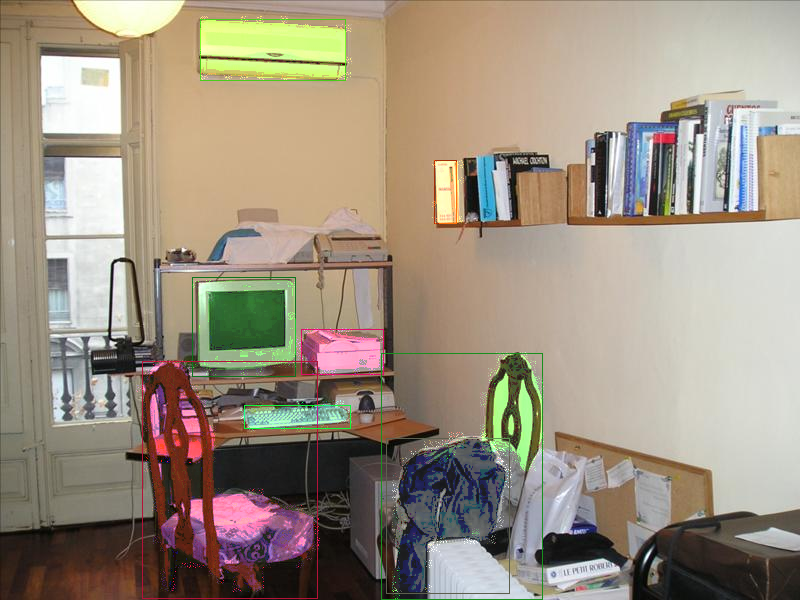

In [79]:
cv2_imshow(image)

In [80]:
cv2.imwrite(f"./out_{_i_}.jpg", image)

True

In [49]:
#save new bbox and mask values
with open(f"scene_graph_updated_{_i_}.json", "w") as new_json_file:
    json.dump(new_json, new_json_file)